# Production rates calculation using PyTorch

This notebook demonstrates the production rates calculation from a `FieldSample`.
There are two opportunities for production rates calculation: from a `Field` (using `numpy`) and from a `FieldSample` (using `torch`).

While requiring some preprocessing, the second method is faster and provides automatic differentiation advantages of the `torch` modules.

In this notebook we will use `FieldSample` (`sample.hdf5`) created in  [08.Dataset_and_Sample.ipynb](./08.Dataset_and_Sample.ipynb).

In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt

from deepfield.metamodelling.rates import RatesModule
from deepfield.datasets import FieldSample
from deepfield.datasets.transforms import ToTensor

from deepfield import Field

PATH_TO_SAMPLE = './sample.hdf5'
PATH_TO_FIELD = '../open_data/norne_simplified/norne_simplified.data'

First of all, let's load the sample. We also will convert it to `torch` since it loads in a `numpy` representation by default.

Also, we cropped the sample at `well_mask` since it will make the visualization easier (though, totally unnecessary).

In [2]:
sample = FieldSample(PATH_TO_SAMPLE).load()
sample.transformed(ToTensor, inplace=True)
sample.at_wells(inplace=True)
dict(**sample.sample_attrs)

{'CONTROL': ['BHPT'],
 'GRID': ['XYZ'],
 'MASKS': ['ACTNUM',
  'TIME',
  'NAMED_WELL_MASK',
  'WELL_MASK',
  'CF_MASK',
  'PERF_MASK'],
 'ROCK': ['PORO', 'PERMX', 'PERMY', 'PERMZ'],
 'STATES': ['PRESSURE', 'SOIL', 'SWAT', 'SGAS', 'RS'],
 'TABLES': ['PVTO', 'PVTW', 'PVDG', 'SWOF', 'SGOF', 'DENSITY']}

Now, we a ready to compute production rates. All the required characteristics are in the `sample.sample_attrs`.

However, in order to show the differentiability of the procedure, we will require gradients for the one of the inputs - `sample.states`:

In [3]:
states = sample.states.requires_grad_()

Now, let's compute the rates.

The key `use_gravitational_adjustment` is required to be `False` for now. Since the function is under development. However, it does not affect the results in a crucial way.

The key `inplace=True` dumps the computed rates into the sample as well as the new attribute `'RATES'` into the `sample_attrs`.

In [4]:
rates_module = RatesModule(units='METRIC')
rates = rates_module(sample, use_gravitational_adjustment=False, inplace=True)

dict(**sample.sample_attrs)

{'CONTROL': ['BHPT'],
 'GRID': ['XYZ'],
 'MASKS': ['ACTNUM',
  'TIME',
  'NAMED_WELL_MASK',
  'WELL_MASK',
  'CF_MASK',
  'PERF_MASK'],
 'ROCK': ['PORO', 'PERMX', 'PERMY', 'PERMZ'],
 'STATES': ['PRESSURE', 'SOIL', 'SWAT', 'SGAS', 'RS'],
 'TABLES': ['PVTO', 'PVTW', 'PVDG', 'SWOF', 'SGOF', 'DENSITY'],
 'RATES': ['BOPR', 'BWPR', 'BGPR']}

The rates are computed for each time stamp the `sample.states` are given and for each perforated computational cell.

In [5]:
print("'rates' shape:", sample.rates.shape)

'rates' shape: torch.Size([247, 3, 504])


Now, we can backpropagate the gradient of the Block Oil Production Rate (BOPR) to the `sample.states`:

In [6]:
bopr, bwpr, bgpr = tuple(sample.rates[:, i] for i in range(len(sample.sample_attrs.rates)))

bopr.sum().backward()

Let's illustrate the dependence of BOPR on the `sample.states`.

<Figure size 432x288 with 0 Axes>

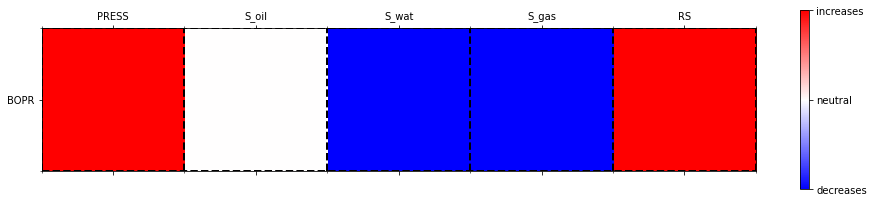

In [7]:
grad = sample.states.grad
grad = grad.mean(axis=(0, 2)).reshape(1, -1)
grad[grad > 0], grad[grad < 0] = 1, -1

plt.figure()
im = plt.matshow(grad, cmap='bwr')
ax = plt.gca()
ax.grid(which='minor', color='k', linestyle='--', linewidth=2)
ax.set_xticks(np.arange(-.5, 5, 1), minor=True)
ax.set_yticks(np.arange(-.5, 1.5, 1), minor=True)
plt.xticks(np.arange(5), ['PRESS', 'S_oil', 'S_wat', 'S_gas', 'RS'])
plt.yticks([0], ['BOPR'])
cbar = plt.colorbar(im, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['decreases', 'neutral', 'increases'])
plt.show()

As you can see from the plot, BOPR increases with the growth of block pressure and gas content. And decreases with the growth of water and gas saturation. This is quite adequate.

It seems strange, that rates are neutral to the oil saturation. However, it is natural: oil saturation does not participate the calculation of the relative oil permeability (water and gas saturations does). Moreover, the saturations are bind together with the equality: $s_{oil} + s_{water} + s_{gas} = 1$. The increase of $s_{oil}$ causes the decrease in $s_{water}$ and $s_{gas}$, thus increasing the BOPR.

Now, let us compare the `torch` calculations with the results of a *standard commercial simulator*.

First of all, we should load the `Field` with these results.

**NOTE:** in order to load the solutions of the *standard simulator* available for the `norne_simplified`, unzip the file with results `../open_data/norne_simplified/RESULTS.zip`.

In [8]:
field = Field(PATH_TO_FIELD).load()
field.wells.drop_incomplete()
field.wells.get_wellblocks(field.grid)
field.wells.apply_perforations()
field.wells.drop_outside()
field.wells.results_to_events(field.grid, drop_duplicates=False)

INFO:Field:Using default config.
INFO:Field:Start reading X files.
INFO:Field:Start reading ../open_data/norne_simplified/RESULTS/norne_simplified.X0000
INFO:Field:Decoding PRESSURE.
INFO:Field:Decoding RS.
INFO:Field:Decoding SGAS.
INFO:Field:Decoding SOIL.
INFO:Field:Decoding SWAT.
INFO:Field:Finish reading ../open_data/norne_simplified/RESULTS/norne_simplified.X0000
INFO:Field:Start reading ../open_data/norne_simplified/RESULTS/norne_simplified.X0001
INFO:Field:Decoding PRESSURE.
INFO:Field:Decoding RS.
INFO:Field:Decoding SGAS.
INFO:Field:Decoding SOIL.
INFO:Field:Decoding SWAT.
INFO:Field:Finish reading ../open_data/norne_simplified/RESULTS/norne_simplified.X0001
INFO:Field:Start reading ../open_data/norne_simplified/RESULTS/norne_simplified.X0002
INFO:Field:Decoding PRESSURE.
INFO:Field:Decoding RS.
INFO:Field:Decoding SGAS.
INFO:Field:Decoding SOIL.
INFO:Field:Decoding SWAT.
...
INFO:Field:[schedule.inc:5371] Loading WCONPROD
INFO:Field:[schedule.inc:5379] Loading WCONINJE
INFO:

We can calculate the field production rates (rates summed across all wells):

In [9]:
dates = field.wells.event_dates
torch_rates = {
    ratename: rate.sum(dim=-1).detach().numpy()
    for ratename, rate in zip(('WOPR', 'WWPR', 'WGPR'), (bopr, bwpr, bgpr))
}
simulator_rates = {ratename: np.zeros_like(rate) for ratename, rate in torch_rates.items()}
for well in field.wells:
    for ratename in simulator_rates:
        simulator_rates[ratename] += well.results[ratename].values[1:]

We can plot the rates for specific wells.
We have chosen two average predictions and one prediction with a significant deviation. 

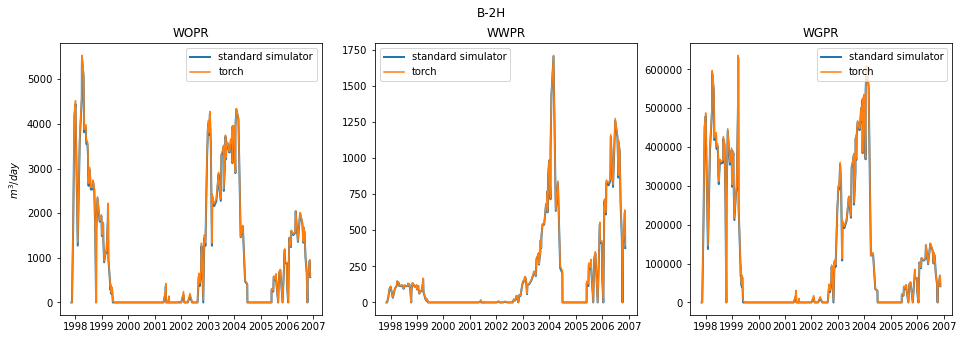

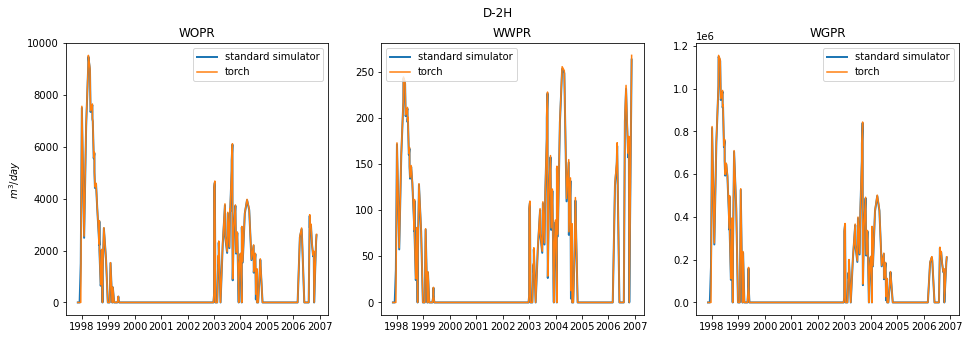

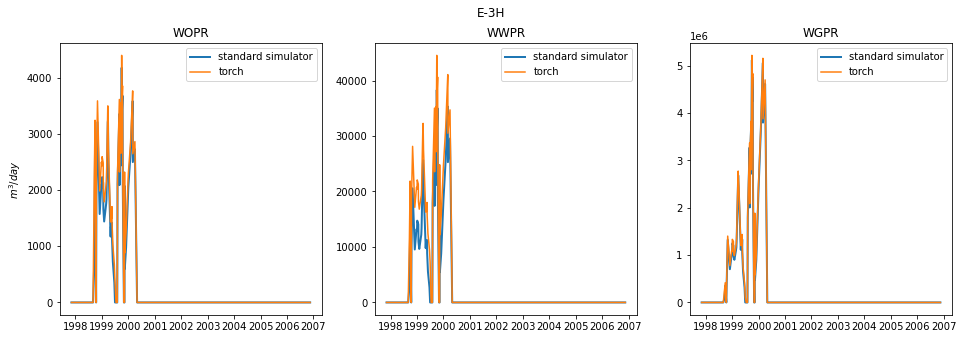

In [10]:
dates = field.wells.event_dates
for well_name in ('B-2H', 'D-2H', 'E-3H'):
    well = field.wells[well_name]
    fig, ax = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle(well_name)
    ax[0].set_ylabel('$m^3/day$')
    for i, (ratename, rate) in enumerate(zip(('WOPR', 'WWPR', 'WGPR'), (bopr, bwpr, bgpr))):
        mask = sample.masks.named_well_mask[well.name].bool()
        ax[i].set_title(ratename)
        ax[i].plot(dates, well.results[ratename].values[1:], lw=2, label='standard simulator')
        ax[i].plot(dates, rate[..., mask].sum(dim=-1).detach().numpy(), label='torch')
        ax[i].legend()
plt.show()

As one can see, caclulated values are close to those obtained using the standard simulator, although it is difficult to guarantee an exact match.